# Fast-Neutron Lab
## Data analysis code and lab notebook

### Introduction
* This 'Jupyter Notebook' is your manual, data analysis and log book all at the same time. It consists of individual cells of text or Python code and you can edit or add cells to your heart's content.
* When using the notebook, there are two modes: *command* and *edit* mode. In command mode, you can add, move, run or delete cells. In edit mode, you modify its content. Use the *Esc* key or click outside the cell to leave edit mode. With *shift* + *return* you can run it directly from edit mode.
* When you 'run' a cell it will either be formated or executed depending on whether it is a text cell or a code cell, respectivly. The output will be shown inside the notebook.
* It is best to run the notebook piece-by-piece as we are progressing through the lab. If something doesn't work as expected, try 'Kernel->Restart' to get a fresh working environment.
* Code cells support typical editing features of an IDE, such as tab-complete. You find more info in the 'Help' menu including all keyboard shortcuts!
* **Please note**: The code is not supposed to work out-of-the-box but needs some tweaks from your side to complete all the way through! So if you encounter an error, don't despair, try to fix it and ask for help should you get stuck!
* **Tip**: If you enable line numbers for code cells in the menu (View->Toggle Line Numbers) it will be easier to discuss changes with your colleagues!

## How to run this analysis
Some initialization in your program:
To plot things, you use the matplotlib library. You need to import the library before the first use and initialize the interactive plots inside the notebook:


In [28]:
import numpy as np
import scipy
# enable interactive notebook plots:
# (alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook
import matplotlib.pyplot as plt

# Plotting the time-of-flight data

* **Before** running this step: place the data file with the Jupyter Notebook
* The aim is to transform the TDC spectrum into a TOF spectrum.
* First you need to import the data and create a histogram.
* There is already a class ready to be used called histhelpers.

Loaded file 'data/tdc.csv' imported from ' Data816.root'


<IPython.core.display.Javascript object>


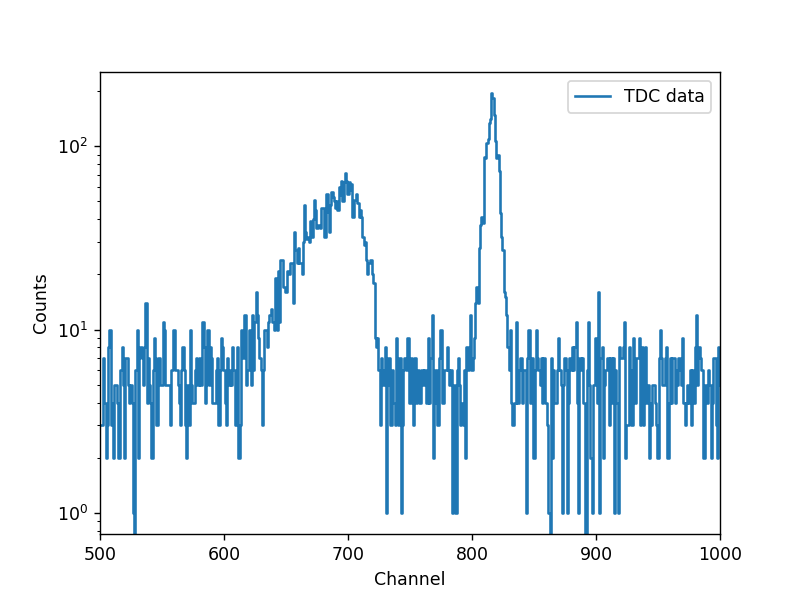

In [29]:
import histhelpers
from histhelpers import getBinCenters
# enter the data from TDC YAP 0
tof = histhelpers.import_hist_from_csv('data/tdc.csv')
print("Loaded file '{}' imported from '{}'".format(tof.filename, tof.name))

plt.figure() # makes new plot
plt.yscale('log')
plt.plot(getBinCenters(tof.bins), tof.data, label="TDC data", drawstyle="steps")
# TODO: add proper axis labels!
plt.xlabel('Channel')
plt.ylabel('Counts') # mind the double-backslash ("escaped")
# TODO: this shows the legend. the label is set in the plotting command.
plt.xlim(500, 1000)
plt.legend()

# Converting the TDC spectrum a to time-of-flight spectrum

* To determine the $T_0$ reference point you need to find the gamma-flash.
* The precise peak position of the gamma flash can be found by fitting a Gaussian to the data.
* First plot the data:

<IPython.core.display.Javascript object>


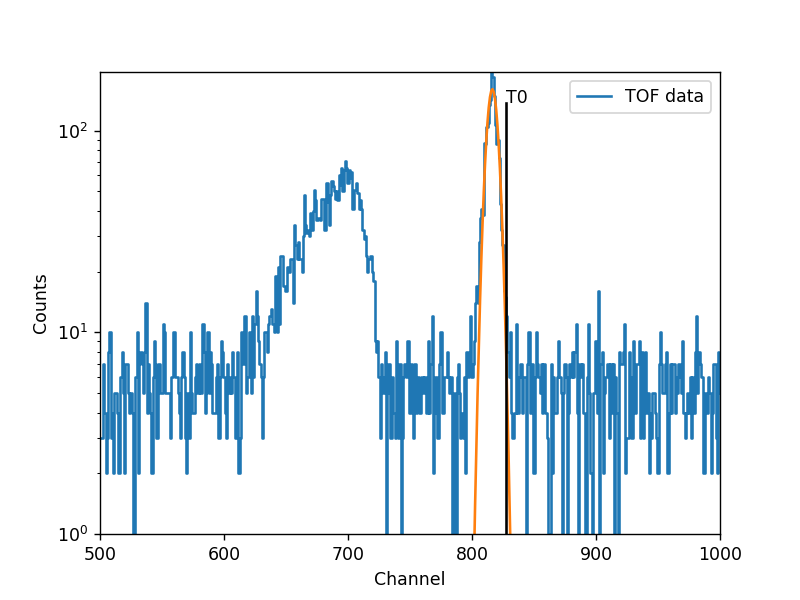

In [31]:
plt.figure()

# plot data
plt.yscale('log') # comment out for lin scale
plt.ylim(ymin=1, ymax=max(tof.data))
plt.plot(getBinCenters(tof.bins), tof.data, label="TOF data", ds="steps") # ds == drawstyle
plt.ylabel("Counts")
plt.xlabel("Channel")
plt.xlim(500, 1000)
plt.legend()

Now adjust the arguments of the routine *fit_gaussians_at_pos* from the *fithelpers.py* file to match the gamma flash position:

In [32]:
import fithelpers
# TODO: adjust position to be fitted in function's argument below
gammaflash_fit = fithelpers.fit_gaussian_at_pos(getBinCenters(tof.bins), tof.data, pos=815)
print(f"gammaflash_fit1: {gammaflash_fit.mu} ch.")
plt.plot(getBinCenters(tof.bins), gammaflash_fit.value(getBinCenters(tof.bins)), label="Gauss Fit")

gammaflash_fit1: 816.4215953154156 ch.


## Optional Challenge: perform the fit on your own!
In the previous cell we "cheated" a bit using ready-made helper code; why not set the parameters yourself and run [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) yourself? You'll find the necessary inspiration in the *Introduction for FYSC12 Labs* Jupyter Notebook you've received.

*Discuss/state below*: What are the uncertainties of the fitted parameters? Is this better than what you would expect reading the values off by eye?

In [50]:
from scipy.optimize import curve_fit #importing fitting library
x_val = tof.bins #TOF values
y_val = tof.data #number of counts

#....... YOUR CODE HERE .......


## Calcuating $T_0$

Now put the correct values in to calcuate the reference time $T_0$:

**Optional**: Document how you determine `seconds_per_TDC_channel` by e.g. creating a new cell where you load the TDC calibration data.

T0 calculated to be at: 827.5867458174077 [ch]


<IPython.core.display.Javascript object>


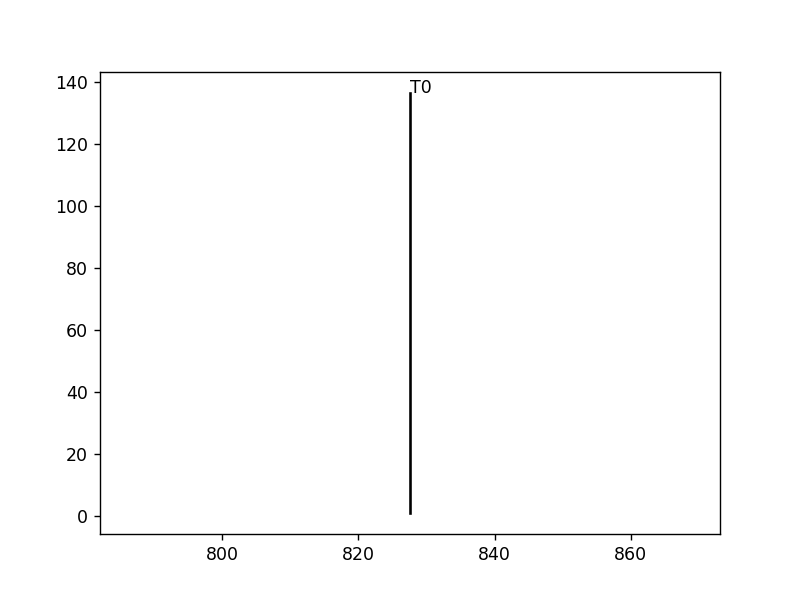

In [36]:
#Enter the distance from detector to neutron source:
distance =  0.965 # in [m]; TODO: measure and put right value here!
speed_of_light = 2.99792458e8 # in [m/s]
gammaflash_position = gammaflash_fit.mu # replace with value read off by eye in case you skipped the fit
seconds_per_TDC_channel = -0.2882982650424511e-9 # in s/ch; TODO: measure and put right value here!


T0 = gammaflash_position - (distance / speed_of_light) * (1/seconds_per_TDC_channel) # TODO: add a calculation here!
print ("T0 calculated to be at: {} [ch]".format(T0))

# DRAW A LINE AT T0:
plt.text(T0, max(tof.data)*.7, "T0")
plt.plot((T0, T0), (1, max(tof.data)*.7), 'k-')

<IPython.core.display.Javascript object>


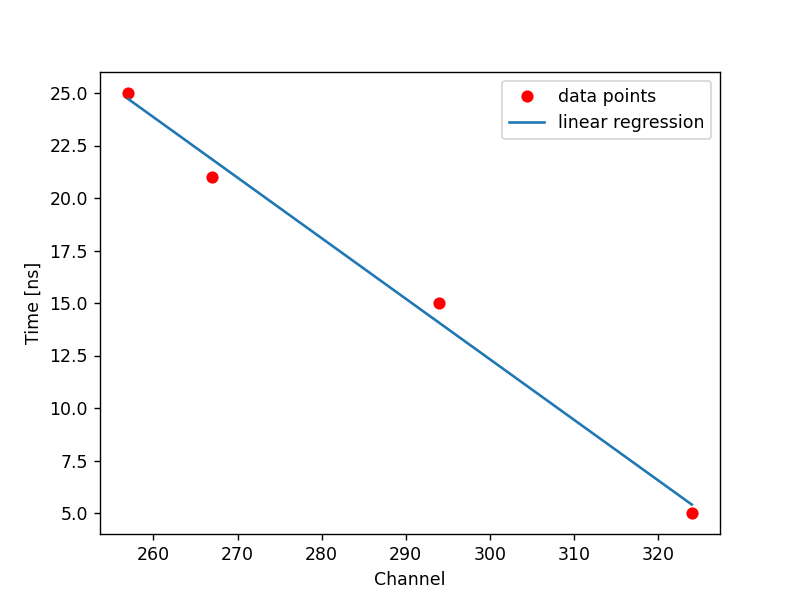

Slope = -0.2882982650424511 ns/ch
0.018423742655544854


In [37]:
from scipy.stats import linregress

time = np.array([324, 294, 267, 257])
channel = np.array([5, 15, 21, 25])
m, y_inter, *a = linregress(time, channel)

plt.figure()
plt.plot(time, channel, 'ro', label="data points")
plt.plot(time, m * time + y_inter, label="linear regression")
plt.xlabel("Channel")
plt.ylabel("Time [ns]")
plt.legend()
print("Slope = {} ns/ch".format(m))
print(a[2])

For clarity, let's put the axis into the correct time binning, invert it and shift the zero position to T0

<IPython.core.display.Javascript object>


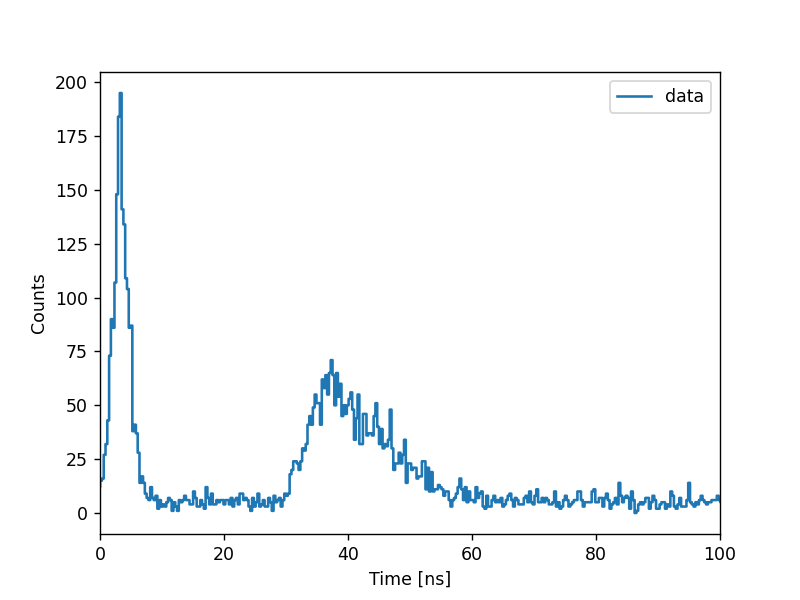

In [38]:
# copy spectrum into new data structure (before messing with it)
import copy
tof_in_ns = copy.deepcopy(tof)

# now align the axis so that 0 =^= T0 and convert TDC channel to time [ns]
tof_in_ns.bins = ((-1) * tof.bins + T0) * -seconds_per_TDC_channel
tof_in_ns.bins *= 1e9 # convert s to ns

# plot the result
plt.figure()
plt.xlabel("Time [ns]")
plt.ylabel("Counts")
plt.xlim(0, 100)
plt.plot(getBinCenters(tof_in_ns.bins), tof_in_ns.data, label="data", ds="steps")
plt.legend()
# plt.yscale('log')


# Clean-up of the spectra and background subtraction
Let's remove "unphysical" part with $t<0$ of the ToF spectrum

<IPython.core.display.Javascript object>


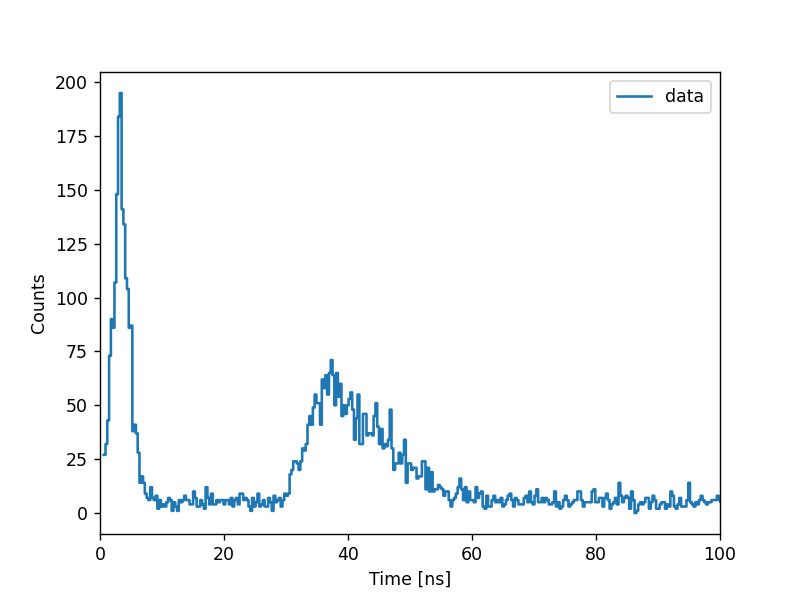

In [39]:
# make copy of spectrum first
tof_stripped = copy.deepcopy(tof_in_ns)

## remove some of the data that would mess up our calculation:
## - find all bins with x > 0, remember last index (just for the very curious -- why last index and not first: the order in memory stays but we flipped the axis when we multiplied with -1 above)
idx_low = np.where(tof_stripped.bins>0)[0][-1]
#idx_high = np.where(Tn.bins>100)[0][-1] # could be used to remove upper part (replaces '0' below)

## strip all other bins to remove those with x < 0
tof_stripped.bins = tof_stripped.bins[0:idx_low]
tof_stripped.data = tof_stripped.data[0:idx_low-1] # mind the offset, len(bins) = len(data)+1 !
# plot the result
plt.figure()
plt.plot(getBinCenters(tof_stripped.bins), tof_stripped.data, label="data", ds="steps")
plt.xlim(0, 100)
plt.xlabel("Time [ns]")
plt.ylabel("Counts")
plt.legend()

## Optional Task: Subtract the random background from the spectrum (you still need to run the cell, even if you don't touch this part otherwise)

Think about (and answer below): How can you best determine the amount of background? What are the implications of removing it? Is this a correction or a purely cosmetic step?

In [21]:
tof_wo_bckgrd = copy.deepcopy(tof_stripped)
# subtract background of random triggers
tof_wo_bckgrd.data -= 0 # TODO: determine (fit?) random background and put here

# values < 0 are unphysical -- set to zero instead
tof_wo_bckgrd.data[tof_wo_bckgrd.data < 0] = 0

# plot the result
plt.figure()
plt.ylim(0.1,max(tof_wo_bckgrd.data))
plt.plot(getBinCenters(tof_wo_bckgrd.bins), tof_wo_bckgrd.data, ds="steps", label="data")

plt.legend()

<IPython.core.display.Javascript object>

# Convert the time-of-flight to an energy spectrum

<IPython.core.display.Javascript object>


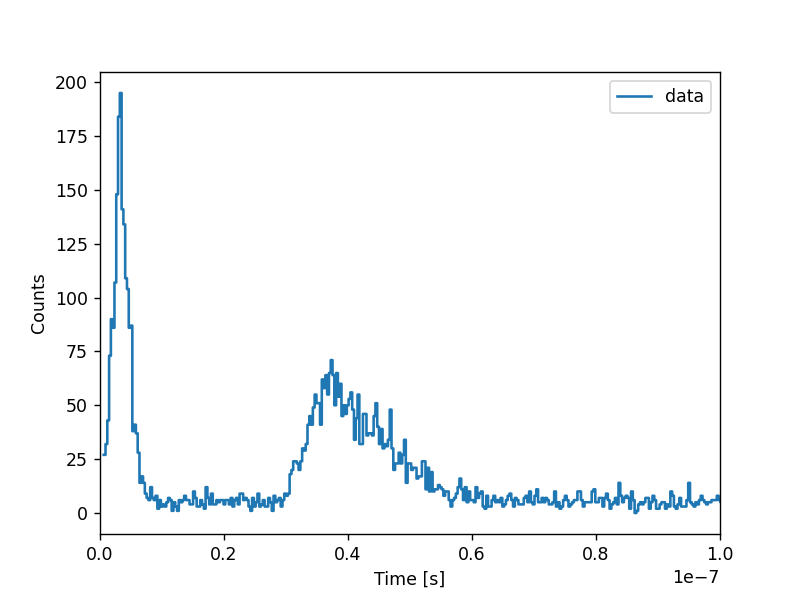

C:\Users\LENOVO\AppData\Local\Temp/ipykernel_2428/2341425600.py:23: RuntimeWarning: invalid value encountered in sqrt
  Tn_rlv.bins = M_n * ( ( 1. / np.sqrt(1. - pow(beta, 2))) - 1. )


<IPython.core.display.Javascript object>


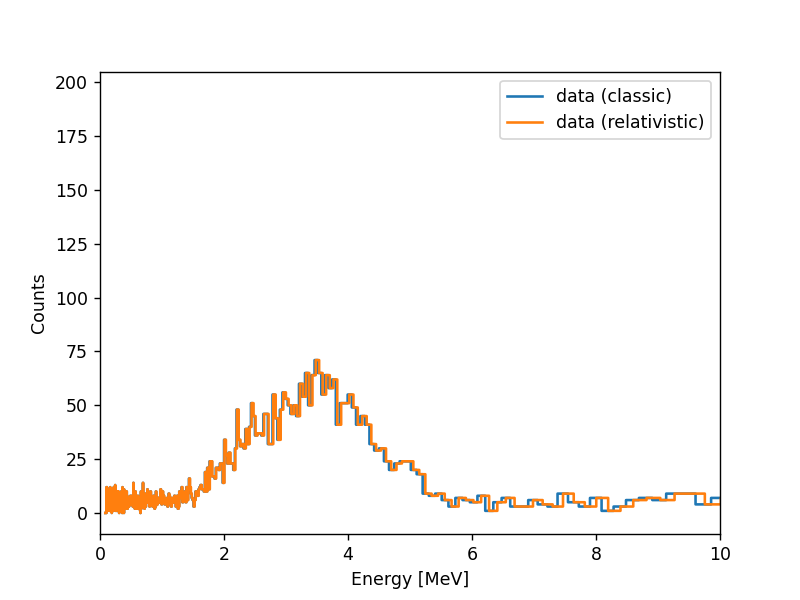

In [40]:
## constants:
#Add neutron mass
M_n = 939.57  ## mass of n in MeV/c**2; TODO: put right value here!

Tn = copy.deepcopy(tof_wo_bckgrd)
Tn.bins *= 1e-9 # convert to seconds

# show the raw data once more for clarity
plt.figure()
plt.plot(getBinCenters(Tn.bins), Tn.data, label="data", drawstyle="steps")
plt.xlim(0, 1e-7)
plt.xlabel("Time [s]")
plt.ylabel("Counts")
plt.legend()


## non-relativistic/classic approach:
Tn_cls = copy.deepcopy(Tn)
Tn_cls.bins = 0.5 * (M_n / pow (speed_of_light, 2)) * ( pow(distance, 2) / pow(Tn_cls.bins, 2) )
## relativistic approach: B. Nilsson PhD thesis, LU, 2003, equation 2.7
Tn_rlv = copy.deepcopy(Tn)
beta = 1. / ( 1. + ((Tn_rlv.bins - distance / speed_of_light) * speed_of_light / distance))
Tn_rlv.bins = M_n * ( ( 1. / np.sqrt(1. - pow(beta, 2))) - 1. )

# plot the result
plt.figure()
plt.plot(getBinCenters(Tn_cls.bins), Tn_cls.data, label="data (classic)", drawstyle="steps")
plt.plot(getBinCenters(Tn_rlv.bins), Tn_rlv.data, label="data (relativistic)", drawstyle="steps")
plt.xlim((0, 10))
plt.xlabel("Energy [MeV]")
plt.ylabel("Counts")
plt.legend()
#plt.yscale('log')
#plt.ylim(ymin=0.1)


# Discussion

Please answer the questions below, make sure that all plots above look good (i.e. show what you want to highlight and are labeled) and submit your Jupyter Notebook.

1. what parameters enter into the calculation to get the energy spectrum from the original data recorded by the TDC?
* what are their uncertainties and how do they affect the result? How can you practically estimate this effect?
* what would you say affects the efficiency of detecting a neutron with today's setup?
* how can you convince your colleagues that you have measured neutrons today?
* what is the background in this technique and how does it affect your measurement?
* compared to charged particles, why is it so difficult to measure the neutron's energy in general?
* what is the function of the CFD ("constant fraction descriminator") module in the setup? Do we actually need it?
* can you come up with suggestions for improvment of this technique?

... and: would you be interested in learning more in an *Advanced Neutron Tagging Lab*? ;)

Parameters that play a role in the calculation of the energies of the emitted neutrons from the source are the distance of travel by the neutron, S and the measured time of flight of the neutrons to cover the same distance S. The velocities of the neutrons are relatively slow compared to the speed of flight hence relativistic effects do not play an important role as it can be seen from the last graph. This means the error from the measurement of the distance between the source to the NE213-detector, S as well as from the computation of the time of flight of the neutrons manifests itself in the energies of the neutrons.

Sources of errors in this experiment include measurement of the distance between the source and the NE213-detectors using a meter rule which has a precision of 0.5mm, the measured signal from $\gamma-\gamma$ used for the calibration of the TDC time resolution, estimation of the $\gamma$-flash by the gaussian fit, and background radiations. The error margin of the distance between the source and the detector can be estimated to be around $\pm1$mm, the time resolution can be made to be more accurate by having more data, the standard error can be obtained from the \textitalic{linregress} function and for the given data was found to be about 0.018 ns/ch.

The efficiency of detecting neutrons was largely affected by the emission of light from the de-excitation of electrons in the scintillators due to interaction with ionizing radiation. Not all neutrons that scatter with the nuclei of the scintillator result in the ionization. About 40-50% of the emitted neutrons are responsible for the emission of light from the scintillators and the energy of the rest is transferred to vibrations and heat. The scattering of the neutrons from the scintillator is determined by the density, chemical composition and thickness of the scintillators. The emission angle of the neutrons also contribute to the efficiency of the experiment as it determines the energy range of the emitted neutrons.

Scintillators emit light with energy that is the function of the energy of the scattered particle. Due to delayed de-excitation progress the type of particle that caused excitation can be determined. When neutrons travel through water to reduce their speed scatter from the scintillator they will cause excitation of electrons which later give off light during the de-excitation process that depends on the energy of the scattered neutrons. Hence, one can be certain that the particles that caused the emission of light are neutrons and not any random particle. The energy of scattered neutrons can then be deduced from the signal generated by the emitted light from the scintillator. This technique result in a spread of energy of the neutrons as the pass through the water. The maximum energy of the neutrons is about 11MeV.

Neutrons are not easy to detect since they are electrically neutral. They do not charge hence they do not cause direct ionization when they interact with a material. Neutral are not affected by the electromagnetic field as well so it's impossible to detected by simply having a strong EM field. Unlike neutrons, protons and electrons are electrically charge thus they can easily be detected using electromagnetic field. In this experiment, neutrons were detected by allowing them to scatter from material and transfer their energy which result in ionization.

Constant fraction discriminator (CFD) is used to modify signal obtained from the neutrons by making sure that the TDC is triggered independent of the amplitude of the signal due different energies of neutron. The CFD archives this by splitting the signal the delaying on the signals before merging them together to create a zero point which will not move in time and can be used as a trigger which is independent of the signal amplitude at the set threshold. the CFD is needed as long as the emitted neutrons are not mono-energetic, meaning the signal not sharp but rather spread out as a function of neutron energies.

The experiment can be improved by making sure that the source of errors is minimized. Thus by making sure more accurate measurement of the distance between the source and the NE213-detectors, taking more measurement for the calibration of TDC time resolution, protect the devices from background radiations and increasing the number of gamma detectors (solid angle).

# Handing in the Notebook

This notebook replaces a formal written report. However, even a lab notebook needs to fullfil:
* Each step you have added should be briefly explained with running text.
* All the usual conventions for figures need to be followed (show relevant region, axis labels, ...)
* Format the text so that the result (when you "run" the cell) looks clear and readable!
* Use proper spelling and full sentences when describing steps or answering questions.
* Proof-read your notebook before submitting it!

We would like you to upload the notebook to Canvas in `pdf` format (if possible). Please choose `Download as -> pdf` from the File menu. Should this not work for you, then pick `html` instead. As a last resort, upload the `.ipynb` notebook file.